## ProjF3 - Baseline Model

In [ ]:
#Importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from keras.models import Sequential
from statsmodels.tsa.arima.model import ARIMA

### 1. Load and Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reading data as a DataFrame
data = pd.read_csv('/content/drive/MyDrive/NNDL/sales_prediction_data.csv')

In [ ]:
data

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0
...,...,...,...,...
957995,2018-03-27,10,50,NaN
957996,2018-03-28,10,50,NaN
957997,2018-03-29,10,50,NaN
957998,2018-03-30,10,50,NaN


In [ ]:
#Checking for duplicate rows in the dataset
print("Duplicate rows:", data.duplicated().sum())

Duplicate rows: 0


In [ ]:
print(data.dtypes)

date      object
store      int64
item       int64
sales    float64
dtype: object


In [ ]:
#Converting 'date' attribute to date type
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


In [ ]:
#Checking for null values in the dataset
data.isna().sum()

date         0
store        0
item         0
sales    45000
dtype: int64

In [ ]:
#Correlation of each attribute with sales
corr = data.corr()
corr['sales'].sort_values(ascending=False)


sales    1.000000
date     0.195909
store   -0.008170
item    -0.055998
Name: sales, dtype: float64

####Since none of the attributes individually exhibit a strong correlation with sales, we have decided to include all attributes in the model. By considering them together, we aim to capture potential interactions and dependencies between the attributes, which can contribute to the effectiveness of the model during training.

In [ ]:
'''Sorting the data according to date as it is a time-stamped dataset and it
would be convinient for traininig the models on sorted data'''

data = data.sort_values('date')

In [ ]:
'''It can be seen that all the null values for sales are from 2018-01-01 to
2018-03-31 as the goal of the competition, from where this dataset is obtained,
is to predict the sales of the stores during this time period using historical
data'''

data[data['sales'].isna()]

,date,store,item,sales
951880,2018-01-01,3,44,NaN
923530,2018-01-01,8,12,NaN
939640,2018-01-01,7,30,NaN
932080,2018-01-01,3,22,NaN
931990,2018-01-01,2,22,NaN
...,...,...,...,...
926229,2018-03-31,7,15,NaN
926139,2018-03-31,6,15,NaN
926049,2018-03-31,5,15,NaN
926949,2018-03-31,5,16,NaN


In [ ]:
#Storing the rows where sales need to be predicted in y (test set)
y = data[data['sales'].isna()]


In [ ]:
y

,date,store,item,sales
951880,2018-01-01,3,44,NaN
923530,2018-01-01,8,12,NaN
939640,2018-01-01,7,30,NaN
932080,2018-01-01,3,22,NaN
931990,2018-01-01,2,22,NaN
...,...,...,...,...
926229,2018-03-31,7,15,NaN
926139,2018-03-31,6,15,NaN
926049,2018-03-31,5,15,NaN
926949,2018-03-31,5,16,NaN


In [ ]:
data = data.drop(y.index)

In [ ]:
data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
#Storing the rest of the data in X (train set)
X = data
X = X.reset_index(drop=True)

In [ ]:
#Printing the train set
X

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-01,3,40,16.0
2,2013-01-01,2,40,20.0
3,2013-01-01,3,6,34.0
4,2013-01-01,1,40,19.0
...,...,...,...,...
912995,2017-12-31,3,24,100.0
912996,2017-12-31,2,47,24.0
912997,2017-12-31,3,2,68.0
912998,2017-12-31,2,1,31.0


In [ ]:
#Printing the test set
y = y.reset_index(drop=True)
y

,date,store,item,sales
0,2018-01-01,3,44,NaN
1,2018-01-01,8,12,NaN
2,2018-01-01,7,30,NaN
3,2018-01-01,3,22,NaN
4,2018-01-01,2,22,NaN
...,...,...,...,...
44995,2018-03-31,7,15,NaN
44996,2018-03-31,6,15,NaN
44997,2018-03-31,5,15,NaN
44998,2018-03-31,5,16,NaN


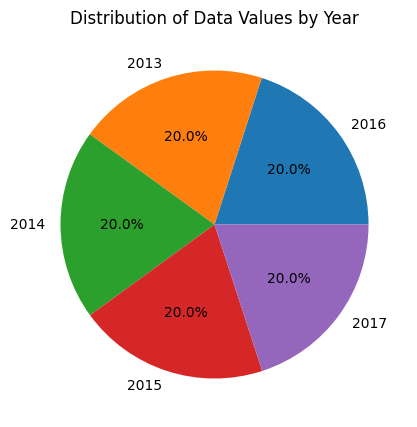

In [ ]:
#Data distribution for each year in train set
X['year'] = X['date'].dt.year


year_counts = X['year'].value_counts()

plt.pie(year_counts, labels=year_counts.index, autopct='%1.1f%%')


plt.title('Distribution of Data Values by Year')


plt.show()


#### As we can see, we do not have any data imbalance in the train set. The data is distributed uniformly for each year.

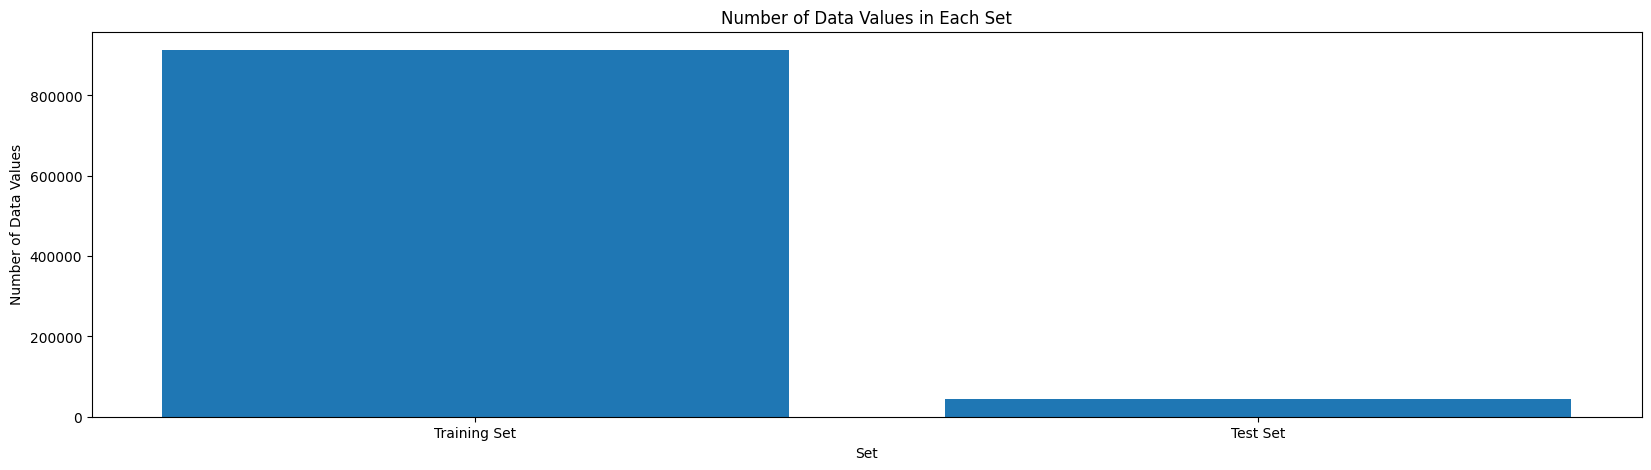

In [ ]:
#Bar plot for showing the data distribution in train and test split

num_train = X.shape[0]
num_test = y.shape[0]

plt.bar(['Training Set', 'Test Set'], [num_train, num_test])

plt.title('Number of Data Values in Each Set')
plt.xlabel('Set')
plt.ylabel('Number of Data Values')

plt.show()


### 2. Preparing Baseline Models

# LSTM

In [ ]:
X_lstm = X

In [ ]:
X_lstm

,date,store,item,sales,year
0,2013-01-01,1,1,13.0,2013
1,2013-01-01,3,40,16.0,2013
2,2013-01-01,2,40,20.0,2013
3,2013-01-01,3,6,34.0,2013
4,2013-01-01,1,40,19.0,2013
...,...,...,...,...,...
912995,2017-12-31,3,24,100.0,2017
912996,2017-12-31,2,47,24.0,2017
912997,2017-12-31,3,2,68.0,2017
912998,2017-12-31,2,1,31.0,2017


In [ ]:
# Converting 'date' column to ordinal to use it as a feature
X_lstm['date'] = X_lstm['date'].apply(lambda x: x.toordinal())

In [ ]:
X_lstm

,date,store,item,sales,year
0,734869,1,1,13.0,2013
1,734869,3,40,16.0,2013
2,734869,2,40,20.0,2013
3,734869,3,6,34.0,2013
4,734869,1,40,19.0,2013
...,...,...,...,...,...
912995,736694,3,24,100.0,2017
912996,736694,2,47,24.0,2017
912997,736694,3,2,68.0,2017
912998,736694,2,1,31.0,2017


In [ ]:
# Dropping 'year' column as it is redundant
X_lstm.drop(columns=['year'], inplace=True)

In [ ]:
# Feature scaling
scaler = MinMaxScaler()
X_lstm[['date', 'store', 'item']] = scaler.fit_transform(X_lstm[['date', 'store', 'item']])
y = scaler.fit_transform(X_lstm[['sales']])

In [ ]:
#X_lstm['date'].unique()

In [ ]:
# Defining function to create sequences
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
# Creating sequences for LSTM model
X_seq, y_seq = create_sequences(X_lstm[['date', 'store', 'item']].values, y)

# Splitting the dataset into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
# Define and compile the LSTM model
lstm_model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
20543/20543 [==============================] - 136s 7ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 2/25
20543/20543 [==============================] - 134s 7ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 3/25
20543/20543 [==============================] - 133s 6ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4/25
20543/20543 [==============================] - 134s 7ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 5/25
20543/20543 [==============================] - 133s 6ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 6/25
20543/20543 [==============================] - 132s 6ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 7/25
20543/20543 [==============================] - 132s 6ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 8/25
20543/20543 [==============================] - 138s 7ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 9/25
20543/20543 [==============================] - 137s 7ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 10/25
20543/20543 [=====================

In [ ]:
# Evaluating the model
test_loss_lstm = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print("Test Loss:", test_loss_lstm)

5707/5707 [==============================] - 18s 3ms/step - loss: 0.0137
Test Loss: 0.013655583374202251


# XGBoost

In [ ]:
X_xg = X

In [ ]:
X_xg

,date,store,item,sales,year
0,2013-01-01,1,1,13.0,2013
1,2013-01-01,3,40,16.0,2013
2,2013-01-01,2,40,20.0,2013
3,2013-01-01,3,6,34.0,2013
4,2013-01-01,1,40,19.0,2013
...,...,...,...,...,...
912995,2017-12-31,3,24,100.0,2017
912996,2017-12-31,2,47,24.0,2017
912997,2017-12-31,3,2,68.0,2017
912998,2017-12-31,2,1,31.0,2017


In [ ]:
X_xg['day'] = X_xg['date'].dt.day
X_xg['month'] = X_xg['date'].dt.month
X_xg['year'] = X_xg['date'].dt.year


X_xg.drop(columns=['date'], inplace=True)

scaler = MinMaxScaler()
X_xg = scaler.fit_transform(X_xg)


y_xg = X_xg[:, -1]


X_xg = X_xg[:, :-1]


In [ ]:
y_xg

array([0., 0., 0., ..., 1., 1., 1.])

In [ ]:
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X_xg, y_xg, test_size=0.2, shuffle=False, random_state = 42)

In [ ]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

model.fit(X_train_xg, y_train_xg)

y_pred_xg = model.predict(X_test_xg)
y_train_pred = model.predict(X_train_xg)
mse_xg_train = mean_squared_error(y_train_xg, y_train_pred)
mse_xg = mean_squared_error(y_test_xg, y_pred_xg)
print("Mean Squared Error Train:", mse_xg_train)
print("Mean Squared Error Test:", mse_xg)


Mean Squared Error Train: 0.09354918944476132
Mean Squared Error Test: 0.09444939327348809


# Random Forest Regresor


In [ ]:
r_x = X

In [ ]:
r_x

,date,store,item,sales,year
0,2013-01-01,1,1,13.0,2013
1,2013-01-01,3,40,16.0,2013
2,2013-01-01,2,40,20.0,2013
3,2013-01-01,3,6,34.0,2013
4,2013-01-01,1,40,19.0,2013
...,...,...,...,...,...
912995,2017-12-31,3,24,100.0,2017
912996,2017-12-31,2,47,24.0,2017
912997,2017-12-31,3,2,68.0,2017
912998,2017-12-31,2,1,31.0,2017


In [ ]:
# Converting 'date' column to ordinal to use it as a feature
r_x['date'] = r_x['date'].apply(lambda x: x.toordinal())

In [ ]:
# Dropping the 'sales' column from features
R_X = r_x.drop(columns=['sales'])

# Target variable for training set
y_train = r_x['sales'].values.reshape(-1, 1)  # Reshape y_train into a 2D array

# Features for training set (dropping 'date' and 'sales' columns)
# X_train = r_x.drop(columns=['date', 'sales'])
X_train = R_X

# Preprocessing: Scale the features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)

In [ ]:
# Splitting the data into training and testing sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [ ]:
n_estimators = 100  # Number of trees in the forest
max_depth = 10      # Maximum depth of the trees
min_samples_split = 2   # Minimum number of samples required to split a node
min_samples_leaf = 1    # Minimum number of samples required to be at a leaf node
max_features = 'auto'   # Number of features to consider when looking for the best split

# Initializing and training the RandomForestRegressor model with customizable hyperparameters
rf_model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=42)
rf_model.fit(X_train_split, y_train_split)


<ipython-input-29-7f3851fc9baf>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_split, y_train_split)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=10, max_features='auto', random_state=42)

In [ ]:
# Predicting on the training set
y_train_pred = rf_model.predict(X_train_split)

# Calculating Mean Squared Error on training set
mse_rf_train = mean_squared_error(y_train_split, y_train_pred)
print("Mean Squared Error on Training Set:", mse_rf_train)

Mean Squared Error on Training Set: 363.8814550120272


In [ ]:
# Predicting on the testing set
y_pred = rf_model.predict(X_test_split)

# Evaluating the model
mse_rf_test = mean_squared_error(y_test_split, y_pred)
print("Mean Squared Error:", mse_rf_test)

Mean Squared Error: 366.57624214952637


# MLP

In [ ]:
r_x = X

In [ ]:
# Converting 'date' column to ordinal to use it as a feature
r_x['date'] = r_x['date'].apply(lambda x: x.toordinal())

In [ ]:
R_X = r_x.drop(columns=['sales'])  # Dropping the 'sales' column from features
y_train = r_x['sales']  # Target variable for training set
#X_train = r_x.drop(columns=['date', 'sales'])  # Features for training set (dropping 'date' and 'sales' columns)
X_train = R_X
# Preprocessing: Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
y = scaler.fit_transform(r_x[['sales']])

# Splitting the data into training and testing sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Define the model architecture
mlp_model = Sequential()
mlp_model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
mlp_model.add(Dense(1, activation='linear'))  # Output layer

# Compile the model
mlp_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
mlp_model.fit(X_train_split, y_train_split, epochs=25, batch_size=32, validation_split=0.1)

# Predicting on the testing set
y_pred_mlp = mlp_model.predict(X_test_split)

# Evaluating the model
mse_mlp = mean_squared_error(y_test_split, y_pred_mlp)
print("Mean Squared Error (MLP):", mse_mlp)


# CNN

In [ ]:
min_max_scaler = MinMaxScaler()

In [ ]:
X_cnn = X


In [ ]:
X_cnn.head()

,date,store,item,sales,year
0,2013-01-01,1,1,13.0,2013
1,2013-01-01,3,40,16.0,2013
2,2013-01-01,2,40,20.0,2013
3,2013-01-01,3,6,34.0,2013
4,2013-01-01,1,40,19.0,2013


In [ ]:
# Preprocess date information (encode dates)
X_cnn['dates'] = (X_cnn['date'] - X_cnn['date'].min()).dt.days

In [ ]:
X_cnn = X_cnn.drop(columns = ['date', 'year'])

In [ ]:
X_cnn = pd.DataFrame(min_max_scaler.fit_transform(X_cnn), columns=X_cnn.columns)

In [ ]:
y_cnn = X_cnn['sales']

In [ ]:
X_cnn = X_cnn.drop(columns=['sales'])

In [ ]:
X_cnn.head()

,store,item,dates
0,0.000000,0.000000,0.0
1,0.222222,0.795918,0.0
2,0.111111,0.795918,0.0
3,0.222222,0.102041,0.0
4,0.000000,0.795918,0.0


In [ ]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.2, shuffle=False)

In [ ]:
# Reshaping input data for Conv1D layer (assuming 1D convolution)

X_train_cnn = X_train_cnn.values.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)
X_test = X_test_cnn.values.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1], 1)

In [ ]:
# Define CNN model architecture
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])


In [ ]:
# Compile the model
cnn_model.compile(optimizer=Adam(), loss='mse')

In [ ]:
# Train the model
history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
20543/20543 [==============================] - 68s 3ms/step - loss: 0.0107 - val_loss: 0.0270
Epoch 2/25
20543/20543 [==============================] - 62s 3ms/step - loss: 0.0089 - val_loss: 0.0364
Epoch 3/25
20543/20543 [==============================] - 61s 3ms/step - loss: 0.0081 - val_loss: 0.0332
Epoch 4/25
20543/20543 [==============================] - 62s 3ms/step - loss: 0.0076 - val_loss: 0.0249
Epoch 5/25
20543/20543 [==============================] - 60s 3ms/step - loss: 0.0073 - val_loss: 0.0230
Epoch 6/25
20543/20543 [==============================] - 61s 3ms/step - loss: 0.0072 - val_loss: 0.0206
Epoch 7/25
20543/20543 [==============================] - 60s 3ms/step - loss: 0.0070 - val_loss: 0.0230
Epoch 8/25
20543/20543 [==============================] - 60s 3ms/step - loss: 0.0071 - val_loss: 0.0186
Epoch 9/25
20543/20543 [==============================] - 62s 3ms/step - loss: 0.0069 - val_loss: 0.0230
Epoch 10/25
20543/20543 [==============================

In [ ]:
# Evaluate the model on test data
loss_cnn = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print("Test Loss:", loss_cnn)

5707/5707 [==============================] - 12s 2ms/step - loss: 0.0605
Test Loss: 0.0605241097509861



# ARIMA


In [ ]:
X_arima = X

In [ ]:
pre_skew = X_arima['sales'].skew()
pre_kurt = X_arima['sales'].kurt()

X_arima['sales'] = np.log1p(X_arima['sales'])

print('Training Set Sales Skew from {%f} downto {%f}' % (pre_skew,X_arima['sales'].skew()))
print('Training Set Sales Kurtosis from {%f} downto {%f}' % (pre_kurt,X_arima['sales'].kurt()))



Training Set Sales Skew from {0.867112} downto {-0.375580}
Training Set Sales Kurtosis from {0.509070} downto {-0.238975}


<ipython-input-23-f1811a806cb8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales = X_arima[X_arima.store==1][X_arima.item==1].sales


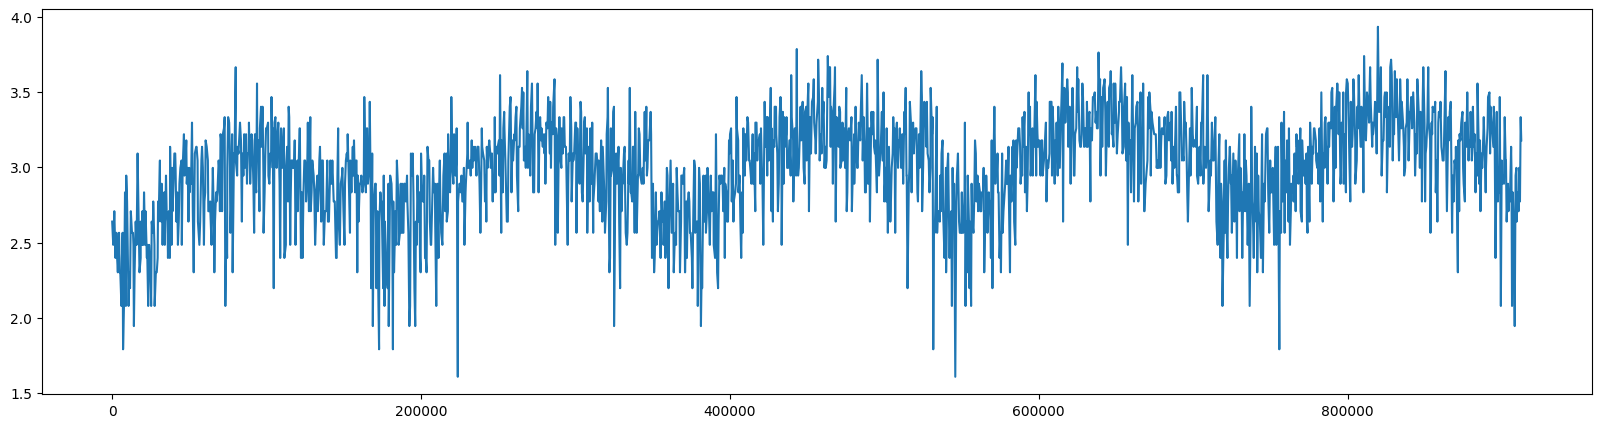

In [ ]:
from pylab import rcParams
sales = X_arima[X_arima.store==1][X_arima.item==1].sales
rcParams['figure.figsize'] = 20, 5
plt.plot(sales)

In [ ]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score

In [ ]:
best_cfg=(7,1,1) # for sales

In [ ]:
rcParams['figure.figsize'] = 20, 5
model = ARIMA(sales, order=best_cfg) # 7 from ar, 1 from diff, 1 for ma.
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -154.199
Date:                Mon, 08 Apr 2024   AIC                            326.399
Time:                        20:22:52   BIC                            375.983
Sample:                             0   HQIC                           344.690
                               - 1826                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0460      0.035      1.315      0.188      -0.023       0.115
ar.L2         -0.0315      0.031     -1.007      0.314      -0.093       0.030
ar.L3         -0.0510      0.031     -1.658      0.0

In [ ]:
mse = mean_squared_error(sales.diff().iloc[1:1001].values, result.predict(start=1,end=1000))
print("The  mean squared error with ARIMA(1,1,0) is {%f}." % mse)

The  mean squared error with ARIMA(1,1,0) is {8.681418}.


In [ ]:
## Now finding the MSE for all other stores and items individually
import warnings
warnings.filterwarnings('ignore')
y = []
y_hat = []
models = {}
for k,si in X_arima[X_arima.store<=3].groupby(['store','item']):
    print(k,si.sales.min(),si.sales.max())
#     y+=(si.sales.diff(1).tolist()[1:])
    model = ARIMA(si.sales.values, order=best_cfg)
    result = model.fit()
#     y_hat+=(result.predict(start=1).tolist())
    models[str(si.store)+'_'+str(si.item)] = result

(1, 1) 1.6094379124341003 3.9318256327243257
(1, 2) 2.639057329615259 4.7535901911063645
(1, 3) 2.1972245773362196 4.2626798770413155
(1, 4) 1.6094379124341003 3.784189633918261
(1, 5) 1.3862943611198906 3.6375861597263857
(1, 6) 2.8903717578961645 4.653960350157523
(1, 7) 2.70805020110221 4.7535901911063645
(1, 8) 3.2188758248682006 4.927253685157205
(1, 9) 2.70805020110221 4.553876891600541
(1, 10) 2.833213344056216 4.882801922586371
(1, 11) 2.4849066497880004 4.8283137373023015
(1, 12) 3.091042453358316 4.897839799950911
(1, 13) 3.332204510175204 4.941642422609304
(1, 14) 3.044522437723423 4.68213122712422
(1, 15) 2.8903717578961645 5.043425116919247
(1, 16) 1.791759469228055 4.02535169073515
(1, 17) 2.302585092994046 4.127134385045092
(1, 18) 3.367295829986474 5.049856007249537
(1, 19) 2.4849066497880004 4.330733340286331
(1, 20) 2.4849066497880004 4.477336814478207
(1, 21) 2.302585092994046 4.31748811353631
(1, 22) 3.258096538021482 4.969813299576001
(1, 23) 1.791759469228055 4.02

In [ ]:
for k,si in X_arima[X_arima.store>3][X_arima.store<=6].groupby(['store','item']):
    print(k,si.sales.min(),si.sales.max())
#     y+=(si.sales.diff(1).tolist()[1:])
    model = ARIMA(si.sales.values, order=best_cfg)
    result = model.fit()
#     y_hat+=(result.predict(start=1).tolist())
    models[str(si.store)+'_'+str(si.item)] = result

(4, 1) 1.6094379124341003 4.007333185232471
(4, 2) 2.639057329615259 4.897839799950911
(4, 3) 2.302585092994046 4.394449154672439
(4, 4) 1.9459101490553132 4.007333185232471
(4, 5) 1.6094379124341003 3.912023005428146
(4, 6) 3.1354942159291497 4.736198448394496
(4, 7) 2.995732273553991 4.770684624465665
(4, 8) 3.295836866004329 5.049856007249537
(4, 9) 2.833213344056216 4.718498871295094
(4, 10) 3.295836866004329 5.043425116919247
(4, 11) 3.258096538021482 4.983606621708336
(4, 12) 3.2188758248682006 5.017279836814924
(4, 13) 3.4339872044851463 5.135798437050262
(4, 14) 3.044522437723423 4.852030263919617
(4, 15) 3.6109179126442243 5.198497031265826
(4, 16) 1.791759469228055 4.1588830833596715
(4, 17) 2.0794415416798357 4.2626798770413155
(4, 18) 3.4965075614664802 5.117993812416755
(4, 19) 2.4849066497880004 4.499809670330265
(4, 20) 2.9444389791664403 4.574710978503383
(4, 21) 2.4849066497880004 4.543294782270004
(4, 22) 3.5263605246161616 5.0238805208462765
(4, 23) 2.079441541679835

In [ ]:
for k,si in X_arima[X_arima.store>6].groupby(['store','item']):
    print(k,si.sales.min(),si.sales.max())
#     y+=(si.sales.diff(1).tolist()[1:])
    model = ARIMA(si.sales.values, order=best_cfg)
    result = model.fit()
#     y_hat+=(result.predict(start=1).tolist())
    models[str(si.store)+'_'+str(si.item)] = result

(7, 1) 0.6931471805599453 3.713572066704308
(7, 2) 2.3978952727983707 4.394449154672439
(7, 3) 2.0794415416798357 4.110873864173311
(7, 4) 1.0986122886681096 3.5553480614894135
(7, 5) 0.6931471805599453 3.4657359027997265
(7, 6) 2.4849066497880004 4.406719247264253
(7, 7) 2.4849066497880004 4.442651256490317
(7, 8) 2.772588722239781 4.68213122712422
(7, 9) 1.9459101490553132 4.3694478524670215
(7, 10) 2.9444389791664403 4.61512051684126
(7, 11) 2.70805020110221 4.605170185988092
(7, 12) 2.5649493574615367 4.624972813284271
(7, 13) 3.044522437723423 4.770684624465665
(7, 14) 2.639057329615259 4.394449154672439
(7, 15) 3.044522437723423 4.812184355372417
(7, 16) 1.3862943611198906 3.828641396489095
(7, 17) 1.6094379124341003 3.9318256327243257
(7, 18) 2.9444389791664403 4.7535901911063645
(7, 19) 1.9459101490553132 4.127134385045092
(7, 20) 2.302585092994046 4.330733340286331
(7, 21) 2.1972245773362196 4.07753744390572
(7, 22) 2.70805020110221 4.727387818712341
(7, 23) 1.3862943611198906

### 3. Baseline Performance


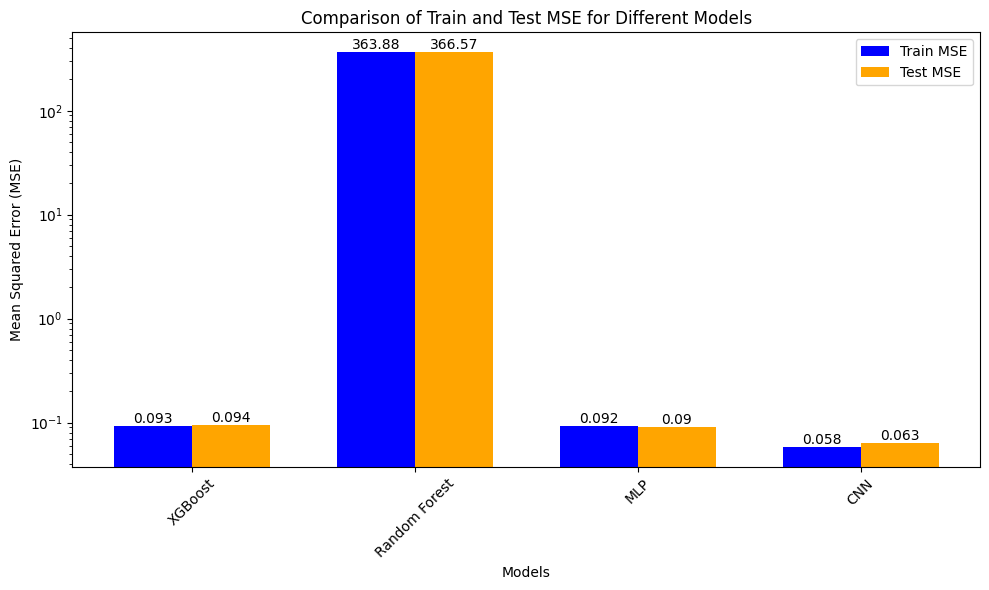

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['XGBoost', 'Random Forest', 'MLP', 'CNN']

# Train MSE values
train_mse = [0.093, 363.88, 0.092, 0.058]

# Test MSE values
test_mse = [0.094, 366.57, 0.090, 0.063]

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(models))

bars1 = plt.bar(index, train_mse, bar_width, color='blue', label='Train MSE')
bars2 = plt.bar(index + bar_width, test_mse, bar_width, color='orange', label='Test MSE')

plt.yscale('log')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Train and Test MSE for Different Models')
plt.legend()
plt.xticks(index + bar_width / 2, models, rotation=45)

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), va='bottom', ha='center')

plt.tight_layout()
plt.show()


### The graph above clearly indicates that the LSTM model surpasses all other models in performance. Following behind is the CNN model, with MLP ranking third. Moving forward with our research, we plan to develop a hybrid architecture by combining the top two performing models, LSTM and CNN. We aim to exceed the predictive capabilities of all baseline models in forecasting sales values.

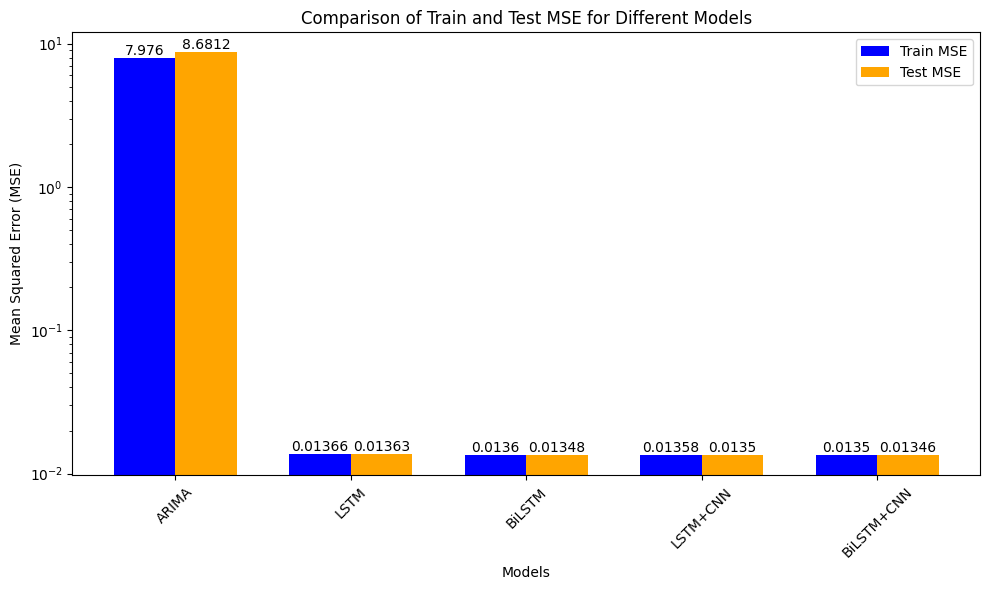

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['ARIMA','LSTM', 'BiLSTM', 'LSTM+CNN', 'BiLSTM+CNN']

# Train MSE values
train_mse = [7.9760, 0.01366, 0.01360, 0.01358, 0.01350]

# Test MSE values
test_mse = [8.6812, 0.01363, 0.01348, 0.01350, 0.01346]

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(models))

bars1 = plt.bar(index, train_mse, bar_width, color='blue', label='Train MSE')
bars2 = plt.bar(index + bar_width, test_mse, bar_width, color='orange', label='Test MSE')

plt.yscale('log')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Train and Test MSE for Different Models')
plt.legend()
plt.xticks(index + bar_width / 2, models, rotation=45)

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 6), va='bottom', ha='center')

plt.tight_layout()
plt.show()


## **The below tables show the prediction of the top 3 models : LSTM, CNN and MLP**

#LSTM

In [ ]:
predicted_values_actual = scaler.inverse_transform(predicted_values.reshape(-1, 1))

# Invert scaling for actual values
y_test_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Round the values to two decimal places
predicted_values_actual_rounded = np.round(predicted_values_actual, decimals=2)
y_test_actual_rounded = np.round(y_test_actual, decimals=2)

# Create DataFrame
df = pd.DataFrame({'Actual Values': y_test_actual_rounded.flatten(),
                   'Predicted Values': predicted_values_actual_rounded.flatten()})


df

,Actual Values,Predicted Values
0,35.0,54.209999
1,52.0,50.070000
2,45.0,39.990002
3,29.0,47.889999
4,115.0,69.099998
...,...,...
182594,101.0,55.560001
182595,27.0,69.839996
182596,115.0,67.620003
182597,29.0,37.779999


#MLP

In [ ]:
predicted_values_actual_mlp = scaler.inverse_transform(y_pred_mlp)

# Invert scaling for actual values
y_test_actual_mlp = scaler.inverse_transform(y_test_split)

# Round the values to two decimal places
predicted_values_actual_rounded_mlp = np.round(predicted_values_actual_mlp, decimals=2)
y_test_actual_rounded_mlp = np.round(y_test_actual_mlp, decimals=2)

# Create DataFrame
df_mlp = pd.DataFrame({'Actual Values': y_test_actual_rounded_mlp.flatten(),
                       'Predicted Values': predicted_values_actual_rounded_mlp.flatten()})

df_mlp

,Actual Values,Predicted Values
0,93.0,65.570000
1,39.0,63.799999
2,80.0,51.919998
3,13.0,38.400002
4,79.0,67.190002
...,...,...
182595,89.0,53.860001
182596,33.0,43.560001
182597,74.0,73.300003
182598,31.0,16.379999


#CNN

In [ ]:
# Predicting on the testing set
y_pred_cnn = cnn_model.predict(X_test_cnn)

# Invert scaling for predicted values
predicted_values_actual_cnn = scaler.inverse_transform(y_pred_cnn)

# Invert scaling for actual values
y_test_actual_cnn = scaler.inverse_transform(y_test_cnn.values.reshape(-1, 1))

# Create DataFrame
df_cnn = pd.DataFrame({'Actual Values': y_test_actual_cnn.flatten(),
                       'Predicted Values': predicted_values_actual_cnn.flatten()})

# Evaluate the model
loss_cnn = cnn_model.evaluate(X_test_cnn, y_test_cnn.values)
print("Test Loss:", loss_cnn)

# Display the DataFrame
df_cnn

5707/5707 [==============================] - 13s 2ms/step - loss: 0.0605
Test Loss: 0.0605241097509861


,Actual Values,Predicted Values
0,55.0,110.167603
1,81.0,112.531418
2,14.0,43.381805
3,74.0,112.234680
4,47.0,103.913979
...,...,...
182595,100.0,159.343536
182596,24.0,115.739159
182597,68.0,68.400398
182598,31.0,34.160236
